# Broth Microdilution Curves Final Figure

- All drugs were read at 100% inhibition
- The final results was determined as follows:
  1. Perform testing in triplicate (each rep from a different McFarland prep)
  2. Use mode from triplicate data, and if there is no mode use the median if it’s in essential agreement (ie 2 4 8 and not 2 4 16)
  3. If there is no mode or median within EA, perform an additional 2 replicates
  4. Use median value for samples with 5 reps
- Only the 4th and 5th result were used to determine the call for the drugs that needed to be repeated although we tested the whole panel. These results is included in the raw data, but are not factored into the final result if repeats were not needed.

In [1]:
import os, sys
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42

%matplotlib inline

## Constants

In [2]:
#############################
#                           #
#                           #
#        CONSTANTS          #
#                           #
#                           #
#############################
LOCAL_DIR = '.'
DATA_DIR = LOCAL_DIR+'/data'
GROWTH_CURVES_DIR = LOCAL_DIR+'/figures/growth_curves'
OUTPUT_DIR = GROWTH_CURVES_DIR+'/broth_microdilution'
if not os.path.exists(GROWTH_CURVES_DIR): os.makedirs(GROWTH_CURVES_DIR)
if not os.path.exists(OUTPUT_DIR): os.makedirs(OUTPUT_DIR)

BROTH_MICRODILUTION_DATA_SHEETNAME = 'growth_broth_microdilution'

MIN_MAX_FRAC_OFFSET = 0.1
MIN_MAX_FRAC_LINE_OFFSET = 0.05
ANTIBIOTIC_DETAILS = {
    'CFZ': {
        'name': 'cefazolin',
        'max': {
            'entered': '>64', 
            'indicator_start': 64,
            'point_plotting_value': 64*2
        },
        'label_offset': 0.92
    },
    'IMP': {
        'name': 'imipenem',
        'label_offset': 0.95
    },
    'AMP': {
        'name': 'ampicillin',
        'max': {
            'entered': '>4096', 
            'indicator_start': 4096,
            'point_plotting_value': 4096*2,
        },
        'label_offset': 0.9
    },
    'INN': {
        'name':'cephalothin',
        'min': {
            'entered': '≤4', 
            'indicator_start': 4,
            'point_plotting_value': 4/2 
        },
        'label_offset': 0.93
    },
    'CAZ': {
        'name':'ceftazidime',
        'label_offset': 0.95
    },
    'MEM': {
        'name':'meropenem',
        'min': {
            'entered': '≤0.12', 
            'indicator_start': 0.12, 
            'point_plotting_value': 0.12/2
        },
        'label_offset': 0.95
    },
    'ATM': {
        'name':'aztreonam',
        'label_offset': 0.95
    },
    'FOX': {
        'name':'cefoxitin',
        'label_offset': 0.98
    }
}

In [3]:
from importlib import reload
sys.path.append(LOCAL_DIR) #Helper Functions Here
import FramHelperScripts
reload(FramHelperScripts)
FHS = FramHelperScripts.FramHelperFunctions(DATA_DIR)

## Load Data

In [4]:
#############################
#                           #
#                           #
#        LOAD DATA          #
#                           #
#                           #
#############################

def correct_numbers_and_names(df):
    '''
    read excel file and correct names and numbers
    '''
    #correct sample names
    df = FHS.add_manuscript_name_to_df(
        df, synonym_column='sample_id', new_column='manuscript_name'
    )

    #fix the greater than / less than min max values for plotting
    def check_min_max(details, val):
        try:
            return float(val)
        except ValueError as e:
            if 'min' in details and val == details['min']['entered']:
                return details['min']['point_plotting_value']
            if 'max' in details and val == details['max']['entered']:
                return details['max']['point_plotting_value']
            if val == 'Invalid': return np.nan
            raise e

    for antibiotic in ANTIBIOTIC_DETAILS.keys():
        details = ANTIBIOTIC_DETAILS[antibiotic]
        df[antibiotic] = df[antibiotic].apply(
            lambda val: check_min_max(details, val)
        )
        df['{0} Result'.format(antibiotic)] = df['{0} Result'.format(antibiotic)].apply(
            lambda val: check_min_max(details, val)
        )
    return df

def filter_replicates(df, antibiotic_code):
    '''
    Munge datafarme, selecting out a particular antibioitic, removing
    the replicates that are not relevant per Kristen's algorithm
    '''
    def valid_replicate(row):
        if antibiotic_code == 'AMP' and \
           row.sample_id=='consensus' and \
           row['Rep # \n(matched rep #, 1-5)'] == 2: 
           #special case for the single invalid number in the spreadsheet
           return False

        if row['Repeat Testing Performed?']=='No': return True
        if row['Rep # \n(matched rep #, 1-5)'] <= 3: return True
        if antibiotic_code in row['Repeated Drug(s)']: return True
        return False

    return df[df.apply(lambda row: valid_replicate(row), axis=1)][[
        'manuscript_name', 'sample_id', 'Rep # \n(matched rep #, 1-5)', 
        antibiotic_code, '{0} Result'.format(antibiotic_code),
    ]]

In [5]:
#Read data
df_orig = correct_numbers_and_names(
    pd.read_excel(
        FHS.get_data_filename(), 
        sheet_name=BROTH_MICRODILUTION_DATA_SHEETNAME
    )
)

sample_order = FHS.get_sample_order(df_orig.manuscript_name)
df_orig = df_orig.assign(
    order = lambda df: df['manuscript_name'].apply(
        lambda s: sample_order.index(s)
    )
).sort_values(by='order')


for antibiotic_code in ANTIBIOTIC_DETAILS:
    ANTIBIOTIC_DETAILS[antibiotic_code]['df'] = filter_replicates(
        df_orig, antibiotic_code
    )

## Plot Figures

Plot the final using the Kristen Roberts (Selux) algorithm:
  1. Perform testing in triplicate (each rep from a different McFarland prep)
  2. Use mode from triplicate data, and if there is no mode use the median if it’s in essential agreement (ie 2 4 8 and not 2 4 16)
  3. If there is no mode or median within EA, perform an additional 2 replicates
  4. Use median value for samples with 5 reps

In [6]:
def plot_final(antibiotic, ax=None, hide_labels=False):
    antibiotic_details = ANTIBIOTIC_DETAILS[antibiotic]
    antibiotic_details_df = ANTIBIOTIC_DETAILS[antibiotic]['df']

    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1)
        fig.set_size_inches(16, 6)
        
    #plot final call
    bottom = np.min(antibiotic_details_df['{0}'.format(antibiotic)])/3
    barplot_plotting_df = antibiotic_details_df[[
        'manuscript_name','{0} Result'.format(antibiotic)]
    ].drop_duplicates()
    
    bpa = ax.bar(
        barplot_plotting_df['manuscript_name'],
        barplot_plotting_df['{0} Result'.format(antibiotic)] - bottom,
        color='lightgray',
        bottom=bottom
    )
    #bpa = sns.barplot(
    #    data=antibiotic_details_df,
    #    x='manuscript_name', y='{0} Result'.format(antibiotic),
    #    color='lightgray', linewidth=1, order=sample_order, errorbar=None,
    #    ax=ax
    #)
    
    #plot raw datapoints, but "smart" jitter so all are visible
    rawdatapoints = {'x':[], 'y': []}
    for design in np.unique(antibiotic_details_df.manuscript_name):
        bar_details = bpa.patches[sample_order.index(design)]
        padding = 0.2 * bar_details.get_width()
        bar_x_start = bar_details.xy[0] + padding
        bar_width = bar_details.get_width() - (2 * padding)

        tmp_df = antibiotic_details_df[
            antibiotic_details_df.manuscript_name==design
        ]
        tmp_df = tmp_df.reset_index()
        rep_spacing = 1 / (len(tmp_df)-1) * bar_width
        for rep_idx, rep_row in tmp_df.iterrows():
            rawdatapoints['x'].append(bar_x_start + (rep_idx * rep_spacing))
            rawdatapoints['y'].append(rep_row[antibiotic])
    ax.scatter(
        x=rawdatapoints['x'], y=rawdatapoints['y'], 
        color='darkred', s=10, zorder=10,
        marker='D', linewidth=0
    )
    
    #add text values to plot
    for design in np.unique(antibiotic_details_df.manuscript_name):
        tmp_df = antibiotic_details_df[
            antibiotic_details_df.manuscript_name==design
        ]

        bar_details = bpa.patches[sample_order.index(design)]

        final_result = np.unique(list(tmp_df['{0} Result'.format(antibiotic)]))[0]
        #if min_result >= 1: final_result = int(final_result)
        if 'max' in ANTIBIOTIC_DETAILS[antibiotic] and \
           final_result == ANTIBIOTIC_DETAILS[antibiotic]['max']['point_plotting_value']:
           final_result = None
        if 'min' in ANTIBIOTIC_DETAILS[antibiotic] and \
           final_result == ANTIBIOTIC_DETAILS[antibiotic]['min']['point_plotting_value']:
           final_result = None

        if final_result is not None:
            ax.text(
                x=bar_details.xy[0] + (bar_details.get_width() / 2), 
                y=bottom*2, #final_result*ANTIBIOTIC_DETAILS[antibiotic]['label_offset'],
                horizontalalignment='center', verticalalignment='top',
                s='{0}'.format(final_result),
                fontsize=8
            )
            
    #plot cutoff
    cutoff_color='red'
    if 'max' in antibiotic_details:
        indicator_y = antibiotic_details['max']['indicator_start']
        ax.axhline(y = indicator_y, color = cutoff_color, linestyle = '--', alpha=0.5)
        ax.text(x=12, y=indicator_y, 
                s='max conc tested', 
                color=cutoff_color)
    if 'min' in antibiotic_details:
        indicator_y = antibiotic_details['min']['indicator_start']
        ax.axhline(y = indicator_y, color = cutoff_color, linestyle = '--', alpha=0.5)
        ax.text(x=0.75, y=indicator_y-(indicator_y*.025), s='min conc tested', color=cutoff_color)

    #set text
    ax.set_title('minimum inhibitory concentration of {0}'.format(
        antibiotic_details['name'])
    )
    ax.set_ylabel('minimum inhibitory concentration {0} (ug/mL)'.format(
        antibiotic_details['name'])
    )
    ax.set_xlabel('design')
    ax.set_yscale('log', base=2)
    ax.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
    
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')

    ax.set_ylim([bottom, ax.get_ylim()[1]])
    
    if hide_labels:
        ax.title.set_visible(False)
        ax.yaxis.label.set_visible(False)
        ax.set_yticklabels([])
        ax.xaxis.label.set_visible(False)
        ax.set_xticklabels([])


## Final Figures

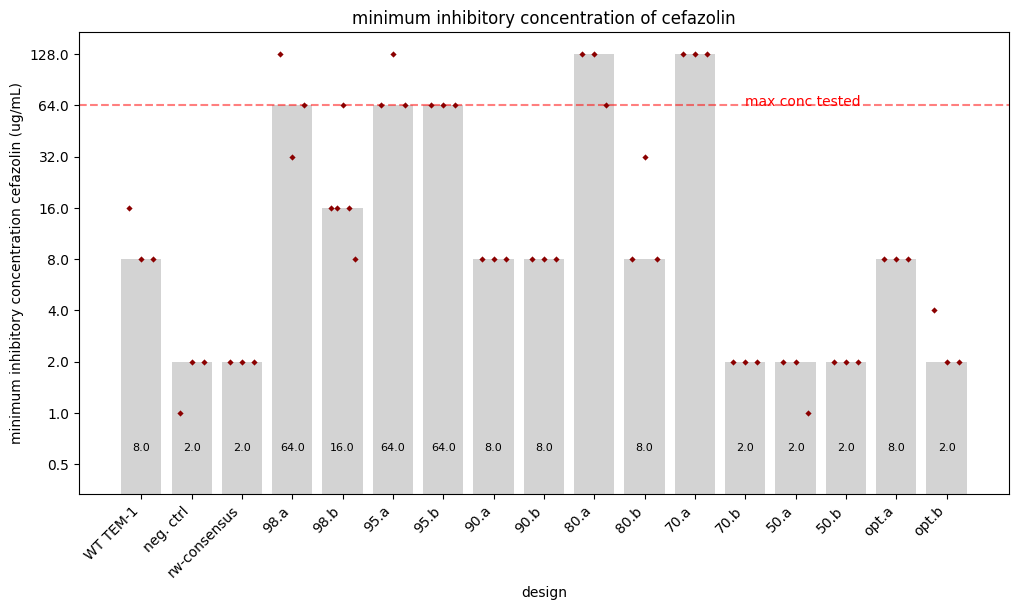

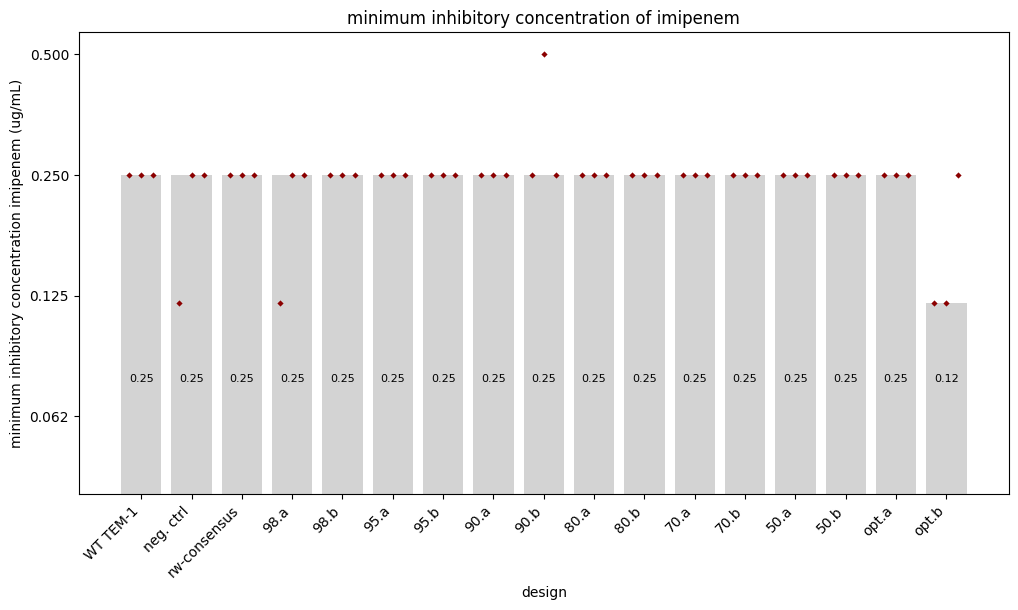

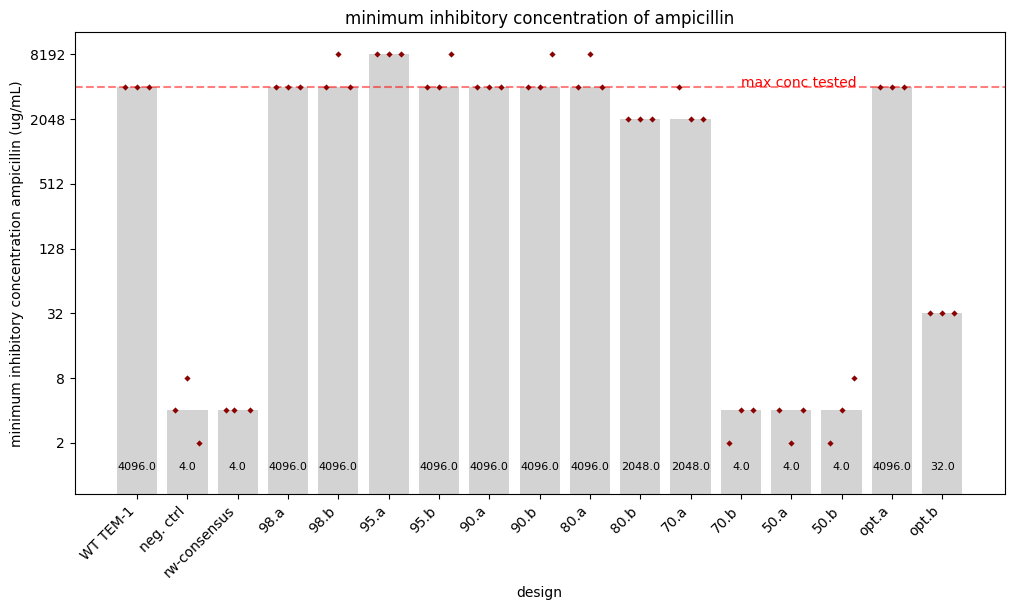

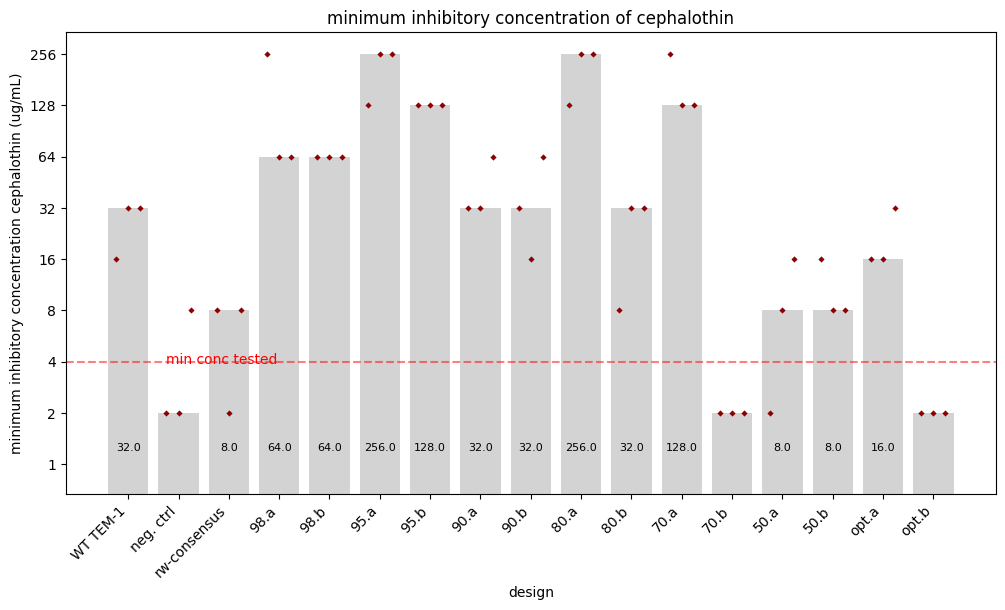

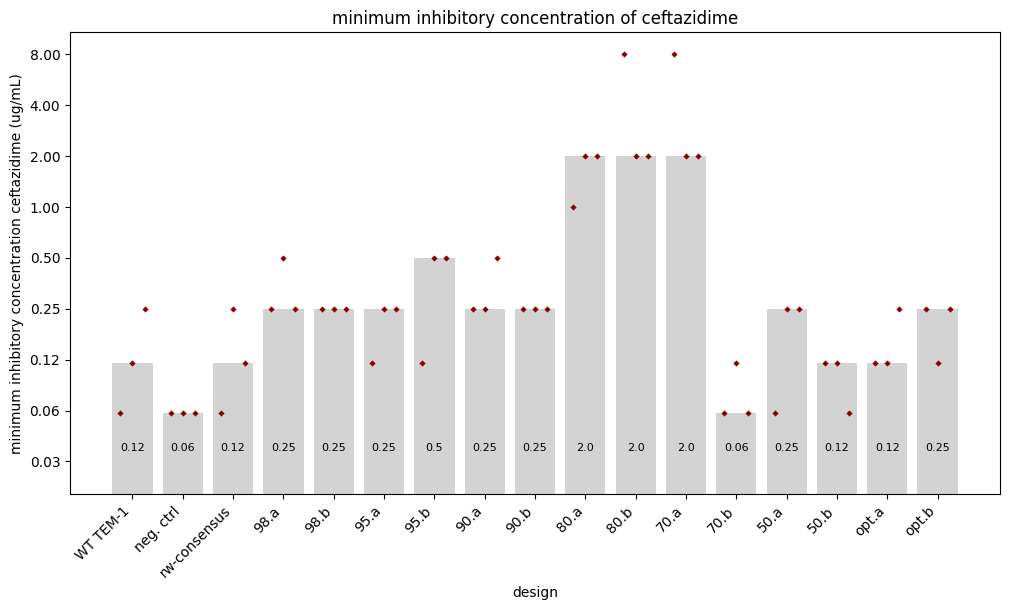

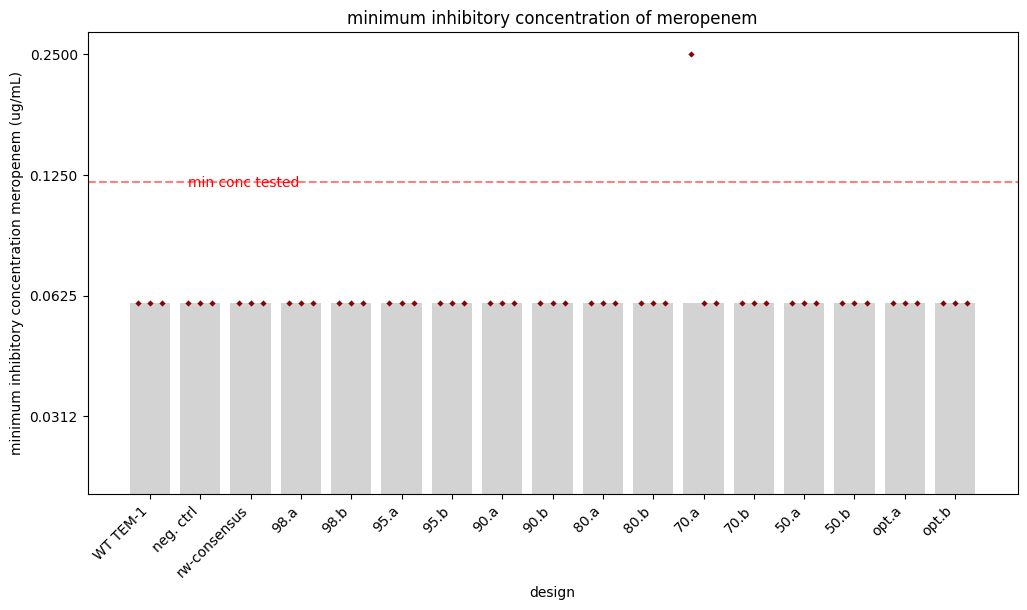

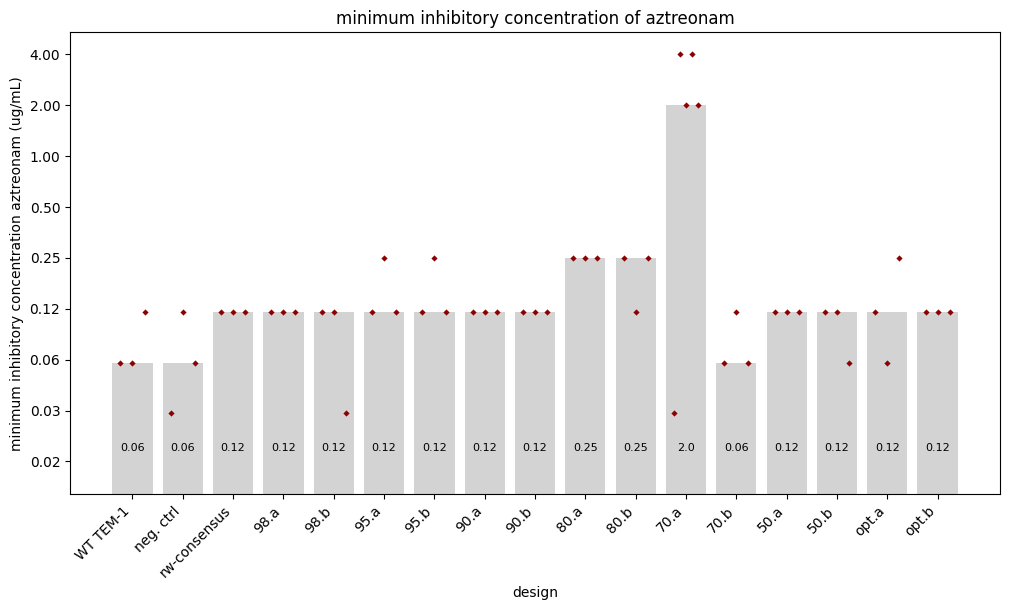

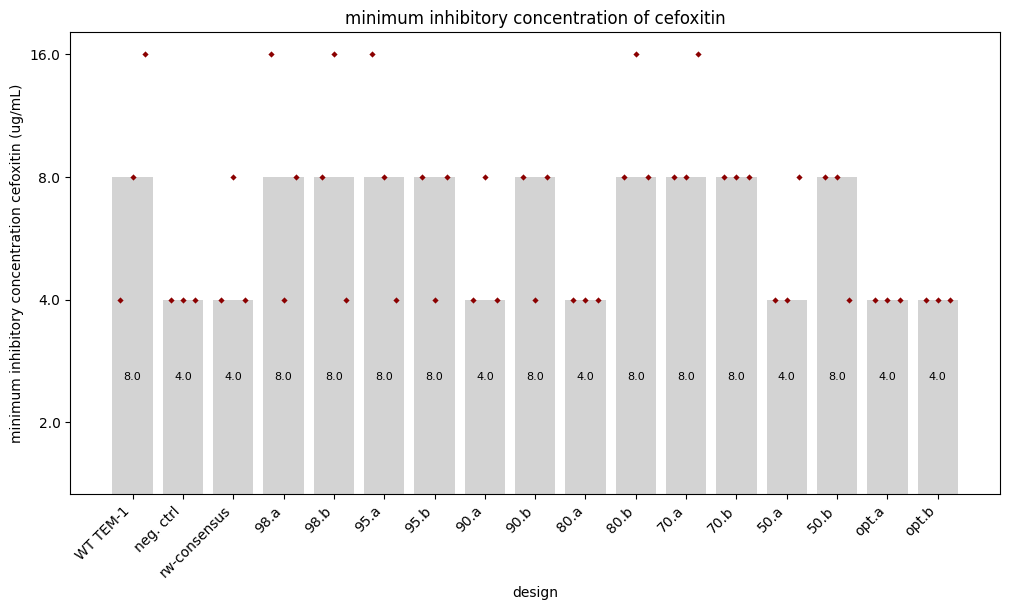

In [7]:
for antibiotic in ANTIBIOTIC_DETAILS.keys():
    fig, ax = plt.subplots(nrows=1, ncols=1)
    fig.set_size_inches(12, 6)
    plot_final(antibiotic, ax=ax)

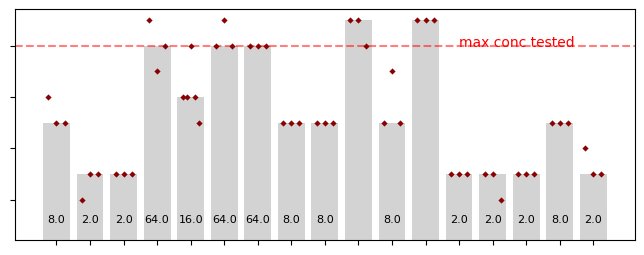

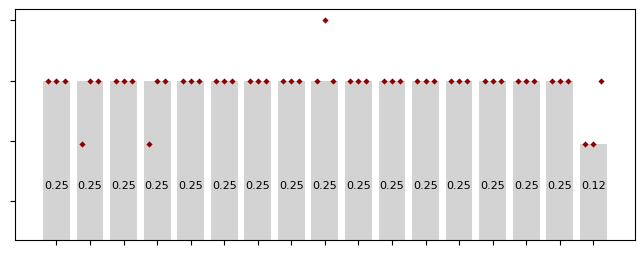

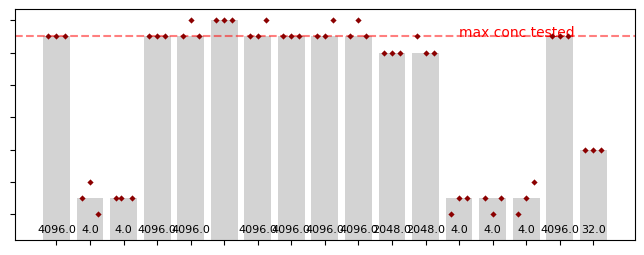

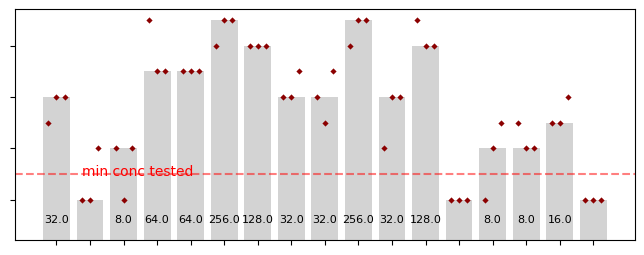

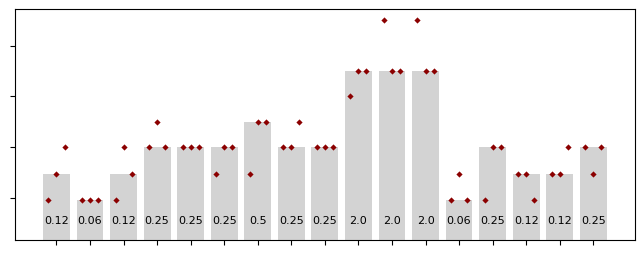

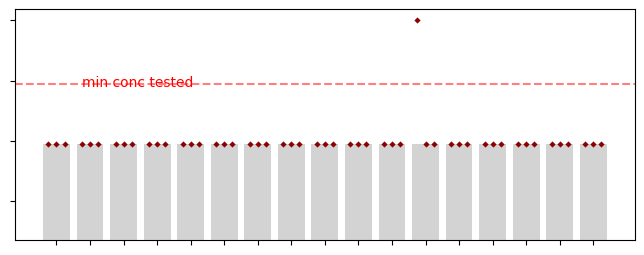

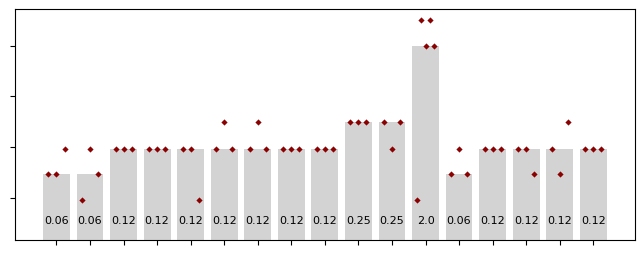

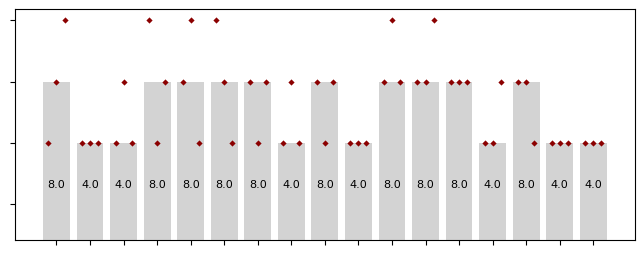

In [8]:
#output for actual PDF - to standardize exact sizing and add labels etc later
for antibiotic in ANTIBIOTIC_DETAILS.keys():
    fig, ax = plt.subplots(nrows=1, ncols=1)
    fig.set_size_inches(8, 3)
    plot_final(antibiotic, ax=ax, hide_labels=True)
    fig.savefig(OUTPUT_DIR+'/brothmicrodilution_{0}_suppfig_all.pdf'.format(antibiotic))